# BS Detector ([Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175)) Demo

Content
1. [Introduction](#section1')
2. [Set up LLM and Prompts](#section2')
3. [Generate Responses and Confidence Scores](#section3')<br>
4. [Performance Evaluation](#section4')

In [1]:
import warnings

import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm.utils import load_example_dataset, math_postprocessor, plot_model_accuracies, Tuner
from uqlm.quantifiers import BSDetector

warnings.filterwarnings("ignore")

2025-03-05 18:16:01.259913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741198561.920933    3568 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741198562.237109    3568 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 18:16:04.468313: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


<a id='section1'></a>
## 1. Introduction

Ensemble UQ methods combine multiple individual scorers to provide a more robust and accurate uncertainty estimate. This demo provides an illustration of an off-the-shelf ensemble method called BS Detector proposed in [Chen & Mueller, 2023](https://arxiv.org/abs/2308.16175). It uses two black-box components: exact match rate and noncontradiction probability, and one LLM-as-a-Judge (self-reflection).

**Pros:**

*   ✅  **Universal Compatibility:** Works with any LLM.
*   ✅  **Intuitive:** Easy to understand and implement.
*   ✅  **No Internal Access Required:** Doesn't need token probabilities or model internals.

**Cons:**

*   ⚠️  **Higher Cost:** Requires multiple generations per prompt.
*   ⚠️  **Slower:**  Multiple generations and comparison calculations increase latency.

<a id='section2'></a>
## 2. Set up LLM and Prompts

In [2]:
# Load example dataset (SVAMP)
svamp = (
    load_example_dataset("svamp")
    .rename(columns={"question_concat": "question", "Answer": "answer"})[
        ["question", "answer"]
    ]
    .head(75)
)
svamp.head()

Loading dataset - svamp...
Processing dataset...
Dataset ready!


,question,answer
0,There are 87 oranges and 290 bananas in Philip...,145
1,Marco and his dad went strawberry picking. Mar...,19
2,Edward spent $ 6 to buy 2 books each book cost...,3
3,Frank was reading through his favorite book. T...,198
4,There were 78 dollars in Olivia's wallet. She ...,63


In [3]:
# Define prompts
MATH_INSTRUCTION = (
    "When you solve this math problem only return the answer with no additional text.\n"
)
prompts = [MATH_INSTRUCTION + prompt for prompt in svamp.question]

In [4]:
# Instantiate BaseChatModel
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model="gemini-pro")

Note that although we use `ChatVertexAI` in this example, any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) may be used.

<a id='section3'></a>
## 3. Generate responses and confidence scores

#### `BSDetector()` - Class for detecting bad and speculative answer from a Large Language Model (LLM Hallucination).

**Class Attributes:**
- `llm` (**BaseChatModel, default=None**) A langchain llm (`BaseChatModel`). User is responsible for specifying temperature and other relevant parameters to the constructor of their `BaseChatModel` object.
- `nli_scorer` - (**class_object, default=None**) A class object to compute the semantic similarity score using a natural language inference model. This object must have a `predict` method, which returns probability of contradiction for provided input. Default case, uses DeBERTA model trained on MNLI dataset.
- `alpha` (**float, default=0.8**) Trade-off parameter to define weightage of similarity score and indicator function score, while computing observed consistency score.
- `beta` - (**float, default=0.7**) Trade-off parameter to define weightage of observed consistency score and self-reflection certainty score.
- `template_ques_ans` - (**str, default=None**) Template to define input prompts for llm model, which includes prompt, response, and question to compute self-reflection certainty score.
- `explanation` - (**boolean, default=False**) It indicates that llm will return an explanation for self refelction question. 
- `device` - (**str or torch.device input or torch.device object, default="cpu"**) Specifies the device that classifiers use for prediction. Set to "cuda" for classifiers to be able to leverage the GPU.
- `system_prompt` - (**str or None, default="You are a helpful assistant."**) Optional argument for user to provide custom system prompt
- `max_calls_per_min` - (**int, default=None**) Specifies how many api calls to make per minute to avoid a rate limit error. By default, no limit is specified.
- `use_n_param` (**bool, default=False**) Specifies whether to use `n` parameter for `BaseChatModel`. Not compatible with all `BaseChatModel` classes. If used, it speeds up the generation process substantially when `num_responses` is large.
- `postprocessor` - (**f(str) -> str, default=None**) A user-defined function to postprocess responses.
- `self_reflection_generator` - (**ResponseGenerator, default=None**) A class object to compute the self-reflection certainty score. If not provided, this method will use defined 'langchain_llm' with 0 temperature.
- `thresh` - (**float, default=0.5**) Threshold for binarizing confidence scores. Not directly used except for tuning.

**Class Methods:**
1. `evaluate` - Generate responses and evaluate confidence scores on LLM responses for the provided prompts..

    **Method Attributes:**
    - `prompts` - (**list of str**) A list of input prompts for the model.
    - `responses` - (**list of str, default=None**) A list of model responses for the prompts. If not provided, this method will generate responses for `self.llm`. 
    - `multiple_responses` - (**list of list of str, default=None**) A list of multiple model responses, each element (multiple_responses[i]) is a list of str, containing multiple model responses for prompts[i]. If not provided, this method will generate responses for `self.llm`.
    - `oc_temperature` - (**float, default=1**) The `temperature` parameter for llm model to generate multiple responses for observed consistency.
    - `num_responses` - (**int, default=5**) The number of multiple responses used to compute observed consistency.

    **Returns:**
        `UQResult` containing data (prompts, responses, and confidence scores) and metadata (parameters, observed consistency data, and self-reflection data)  
        
2. `tune_params` - Tunes alpha, beta, and thresh parameters on a set of user-provided graded responses. 

    **Method Attributes:**
    - `correct_indicators` - (**list of bool**) A list of boolean indicators of whether self.original_responses are correct.
    - `bounds` - (**list of 2-tuples of floats, default = [(0,1), (0,1), (0,1)]**) Bounds of parameters for alpha, beta, thresh for scipy minimize function. 
    - `alpha_beta_objective` - (**{'fbeta_score', 'accuracy_score', 'balanced_accuracy_score', 'roc_auc', 'log_loss'}, default='fbeta_score'**)Objective function for optimization of alpha and beta. Must match thresh_objective if one of 'fbeta_score', 'accuracy_score', 'balanced_accuracy_score'. If same as thresh_objective, joint optimization will be done. 
    - `thresh_objective` - (**{'fbeta_score', 'accuracy_score', 'balanced_accuracy_score', 'roc_auc', 'log_loss'}, default='fbeta_score'**) A list of boolean indicators of whether self.original_responses are correct.
    - `n_trials` - (**int, default=100**) Indicates how many candidates to search over with optuna optimizer
    - `grid_search_alpha_beta` - (**bool, default=False**) Indicates whether to conduct grid search as optimization routine for alpha and beta
    - `step_size` - (**float, default=0.01**) Indicates step size in grid search, if used
    - `fscore_beta` - (**float, default=1**) Value of beta in fbeta_score  

    **Returns:**
        `UQResult` containing data (prompts, responses, and confidence scores) and metadata (parameters, observed consistency data, and self-reflection data)  

In [5]:
import torch

device = torch.device("cuda")  # use if GPU available
# device = None

In [6]:
bsd = BSDetector(
    llm=llm,
    device=device,
    max_calls_per_min=125,
    # postprocessor=math_postprocessor,
    use_n_param=False,  # Set True if using AzureChatOpenAI for faster generation
)

'self_reflection_generator' is None, creating new object for this attribute...


Some weights of the model checkpoint at microsoft/deberta-large-mnli were not used when initializing DebertaForSequenceClassification: ['config']
- This IS expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# Generate responses and scores
result = await bsd.evaluate(
    prompts=prompts,
    num_responses=5,
    # responses=responses # provide if responses already generated
    # multiple_responses=multiple_responses # provide if candidate responses already generated
)

Generating responses...
Generating candidate responses...
Computing observed consistency scores...
Generating LLMJudge scores...
Confidence scores successfully computed!


In [8]:
# preview results
result_df = result.to_df()
result_df.head(5)

,prompt,response,confidence_score,multiple_responses,self_reflection_score,observed_consistency_score,nli_score,indicator_score
0,When you solve this math problem only return t...,145,0.671730,"[145, 145\n, 145, 145, 145]",0.0,0.959614,0.999518,0.8
1,When you solve this math problem only return t...,19,0.658692,"[19, 19, 19, 19, 19 pounds]",0.0,0.940989,0.976236,0.8
2,When you solve this math problem only return t...,$3,0.574740,"[$3.00, 3, $3, $ 3.00, $3.00]",0.0,0.821057,0.976321,0.2
3,When you solve this math problem only return t...,198,0.971762,"[198, 198\n, 198, 198, 198]",1.0,0.959660,0.999575,0.8
4,When you solve this math problem only return t...,63,0.895855,"[63 dollars., 63 dollars, 63, 63, $63]",1.0,0.851221,0.964027,0.4


<a id='section4'></a>
## 4. Evaluate performance

In [9]:
# Populate correct answers and grade responses
result_df["answer"] = svamp.answer
result_df["response_correct"] = [
    math_postprocessor(r) == a for r, a in zip(result_df["response"], svamp["answer"])
]
result_df.head(5)

,prompt,response,confidence_score,multiple_responses,self_reflection_score,observed_consistency_score,nli_score,indicator_score,answer,response_correct
0,When you solve this math problem only return t...,145,0.671730,"[145, 145\n, 145, 145, 145]",0.0,0.959614,0.999518,0.8,145,True
1,When you solve this math problem only return t...,19,0.658692,"[19, 19, 19, 19, 19 pounds]",0.0,0.940989,0.976236,0.8,19,True
2,When you solve this math problem only return t...,$3,0.574740,"[$3.00, 3, $3, $ 3.00, $3.00]",0.0,0.821057,0.976321,0.2,3,True
3,When you solve this math problem only return t...,198,0.971762,"[198, 198\n, 198, 198, 198]",1.0,0.959660,0.999575,0.8,198,True
4,When you solve this math problem only return t...,63,0.895855,"[63 dollars., 63 dollars, 63, 63, $63]",1.0,0.851221,0.964027,0.4,63,True


In [10]:
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.6933333333333334


Next we will plot filtered LLM accuracy at various confidence score thresholds. The idea is to measure the LLM's performance when we consider responses with confidence scores above a given threshold.

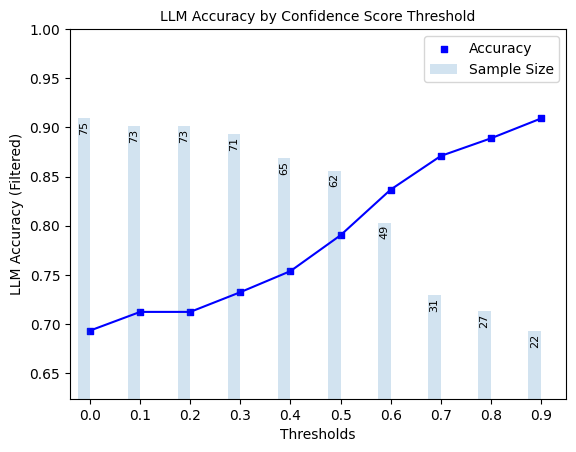

In [11]:
plot_model_accuracies(
    scores=result_df.confidence_score, correct_indicators=result_df.response_correct
)

Lastly, we will compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using this threshold, we can compute precision, recall, and F1-score for BS Detector predictions of whether responses are correct.

In [12]:
# instantiate UQLM tuner object for threshold selection
t = Tuner()

# Define score vector and corresponding correct indicators (i.e. ground truth)
y_scores = result_df["confidence_score"]  # confidence score
correct_indicators = (
    result_df.response_correct
) * 1  # Whether responses is actually correct

# Solve for threshold that maximizes F1-score
best_threshold = t.tune_threshold(
    y_scores=y_scores,
    correct_indicators=correct_indicators,
    thresh_objective="fbeta_score",
)
y_pred = [
    (s > best_threshold) * 1 for s in y_scores
]  # predicts whether response is correct based on confidence score
print(f"BS Detector F1-optimal threshold: {best_threshold}")

BS Detector F1-optimal threshold: 0.5


In [13]:
# evaluate precision, recall, and f1-score of BS Detector predictions of correctness
print(
    f"BS Detector precision: {precision_score(y_true=correct_indicators, y_pred=y_pred)}"
)
print(f"BS Detector recall: {recall_score(y_true=correct_indicators, y_pred=y_pred)}")
print(f"BS Detector f1-score: {f1_score(y_true=correct_indicators, y_pred=y_pred)}")

BS Detector precision: 0.7903225806451613
BS Detector recall: 0.9423076923076923
BS Detector f1-score: 0.8596491228070176
